# Project 목표
 : 얼굴이 나온 셀카 이미지에 얼굴인식 기술을 적용시켜 고양이수염 스티커를 입혀보자

## 1. Image 처리

In [1]:
# image를 읽고 processing한 후 출력을 할때 사용할 라이브라리들 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
!pwd

/home/aiffel/aiffel


원본 이미지 size :  (540, 960, 3)


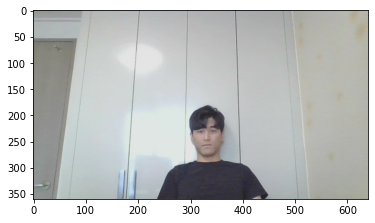

In [3]:
import copy

# 사용할 이미지가 저장된 path 저장
my_image_path = os.getenv('HOME')+'/camera_sticker/images/6.jpg' 
# opencv를 통한 image read
img_bgr = cv2.imread(my_image_path)
print('원본 이미지 size : ', img_bgr.shape)
# 수월한 이미지 처리를 위한 image resize
img_bgr = cv2.resize(img_bgr, (640, 360))
# opencv imread 함수는 image를 BGR 포멧으로 읽어오기에 RGB포멧으로 바꿔준다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# 최종 사용될 이미지를 위하여 deepcopy를 통해 copy
img_origin = copy.deepcopy(img_rgb)

plt.imshow(img_origin)
plt.show()

# 2. HoG Detector of dlib for face detection
 -> extract bounding box 

In [4]:
import dlib

# 얼굴 인식을 위한 dlib의 fhog_object_detector객체 생성
detector_hog = dlib.get_frontal_face_detector() 
print(type(detector_hog))

<class '_dlib_pybind11.fhog_object_detector'>


- ### detector를 이용하여 얼굴의 bounding box 추출

In [5]:
# 2번 unsampling을 해주어 좀더 정밀하게 bounding box를 추출 하였다
dlib_rects = detector_hog(img_rgb, 2)
print(dlib_rects)

rectangles[[(297, 212) (362, 277)]]


In [6]:
#detector_hog.run(img_rgb, 1)

- ### fhog_object_detector를 거쳐 이미지 속 인식한 하나의 dlib_rects의 좌표 정보를 가지고 <br> cv의 rectangle 함수를 통해 이미지에 bounding box를 그려준다

w, h of bounding box : 66 66
w, h of bounding box : 66 66


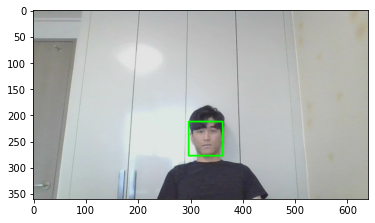

In [7]:
l = dlib_rects[0].left()
t = dlib_rects[0].top()
r = dlib_rects[0].right()
b = dlib_rects[0].bottom()

w = dlib_rects[0].width() # = dlib_rects[0].right() - dlib_rects[0].left() - 1 
h = dlib_rects[0].height() # = dlib_rects[0].bottom() - dlib_rects[0].top() - 1

print('w, h of bounding box :', w, h)

# fhog_object_detector의 반환 rect의 사이즈가 (nxn) 의 정사각형이 나올 때도 있고,
# (n x n+1) 형태로 개같이 나올때도있다. w, h 중 뭐가 클지도 모른다.
# 이렇게 정사각형이 아닐 경우 뒤에 sticker를 bouning box에 일정 비율로 resize시킨 후
# ROI와 resize시킨 sticker의 shape가 다를 수 있기에 bouning box의 w,h를 미리 조절 해주어야 한다
# cv2.rectangle 자체는 sticker에 영향이 없으므로 건들지 않는다

if w != h :
    if w > h :
        w -= 1
    else : 
        h -= 1

cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)


print('w, h of bounding box :', w, h)

plt.imshow(img_rgb)
plt.show()

# 3. detect face landmark for dlib pre-trainted model

- ### Dlib에서 제공하는 regression tree esemble모델을 통해 ibug 300-W dataset을 학습한 모델을 사용하여 직전에 인식한 bounding box 속에서 landmark를 찾는다.

In [8]:
# 학습된 모델 객체 생성
model_path = os.getenv('HOME')+'/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [9]:
list_landmarks = []

# 직전에 불러온 학습된 model인 landmark_predictor 에 이미지와 bouning box를 인자로 넘겨 
# landmark pointer set을 가진 객체를 반환받는다.
points = landmark_predictor(img_rgb, dlib_rects[0])
# points 객체가 가진 64개의 landmark x,y point를 tuple로 매핑시킨후 리스트에 담는다.
list_points = list(map(lambda p: (p.x, p.y), points.parts()))
list_landmarks.append(list_points)
# 하나의 bounding box에대한 landmark list 한개 set만 있으니 
# 햇갈리지 않게 변수명을 바꿔준다

print(len(list_landmarks))

list_landmark = list_landmarks[0]

print('landmark point 갯수 : ',len(list_landmark))

1
landmark point 갯수 :  68


- ### 이제 찾은 landmark point를 이미지에 점으로 찍어보자

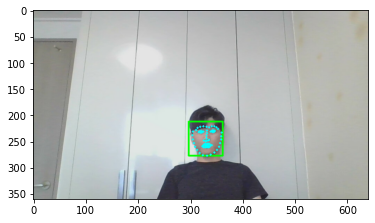

In [10]:
for idx, point in enumerate(list_points):
    cv2.circle(img_rgb, point, 2, (0, 255, 255), -1)

plt.imshow(img_rgb)
plt.show()

# 4. sticker image processing

- ### 우선 원본 이미지에 입힐 스티거 이미지를 불러와 살펴보자

sticker size :  (512, 512, 3)


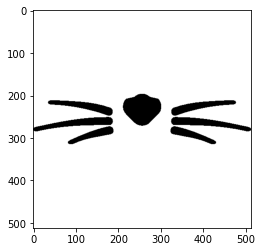

In [11]:
sticker_path = os.getenv('HOME')+'/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
print('sticker size : ',img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

- ### sticker image가 color 로 읽어왔지만 검정색과 흰색만보여 각 채널별 값을 살펴보았다

In [12]:
import pandas as pd

df_0 = pd.DataFrame(img_sticker[:,:,0].ravel())
df_1 = pd.DataFrame(img_sticker[:,:,1].ravel())
df_2 = pd.DataFrame(img_sticker[:,:,2].ravel())

print('sticker ch0 : \n',df_0.value_counts(),'\n')
print('sticker ch1 : \n',df_1.value_counts(),'\n')
print('sticker ch2 : \n',df_2.value_counts(),'\n')

sticker ch0 : 
 255    244252
0       17892
dtype: int64 

sticker ch1 : 
 255    244252
0       17892
dtype: int64 

sticker ch2 : 
 255    244252
0       17892
dtype: int64 



- ### 각 채널마다 동일한 형태의 값을 가졌으며 0과 255 로 이루어져 binary 처리하기 좋아보인다

- ### 일단 sticker image의 센터 좌표가 위치할 적합한 landmark point를 찾는다 <br> (그냥 스티커가 적절하게 얼굴에 들어맞을 위치를 대강 내 눈으로 찾는다)
- ### 추가로 dlib의 frontal_face_detector 그리고 landmark_predictor 가 인식 할 수있는 최대의 기울임 정도까지 커버하고자 얼굴이 기울어진 정도를 landmark를 통해 계산하여 그만큼 sticker도 기울여 적용할 것이다.

proper landmark point for sticker's center:  (331, 244)


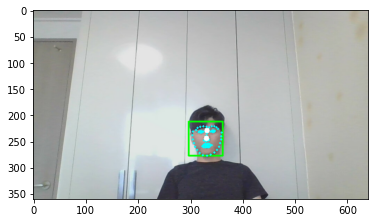

In [13]:
cv2.circle(img_rgb, list_points[30], 5, (255, 255, 255), -1) # center point
cv2.circle(img_rgb, list_points[27], 5, (255, 255, 255), -1) # point for calculate gradient
print('proper landmark point for sticker\'s center: ', list_points[30])
plt.imshow(img_rgb)
plt.show()

- ### 두 landmark(코 시작 landmark, 코 끝 landmark : 위 이미지의 하얀 두점) 간 degree 계산을 통해 얼굴이 기울어진 정도를 계산

In [14]:
import math

radian = math.atan2(list_points[30][0] - list_points[27][0], list_points[30][1] - list_points[27][1])
radian2 = math.atan2(list_points[27][0] - list_points[30][0], list_points[27][1] - list_points[30][1])

degree = radian * 180 / math.pi
if degree < 0 :
    degree += 360
degree = int(degree)
print('degree : ', degree)

degree :  356


- ### box size가 134 x 134 이고 sticker의 size가 (512, 512) 이므로 적절한 비율로 스티커 사이즈를 조절 해준다
##### -> bouning box의 반 size는 너무 작고 2/3 은 logic이 복잡해져 그냥 bouning box 크기에 1:1 비율료 맞춤.

# 5. Sticker image rotation
- ### 앞 서 계산한 degree를 토대로 rotate

255    233998
0       24720
239        99
16         97
207        93
        ...  
102         1
176         1
99          1
92          1
130         1
Length: 229, dtype: int64
255    233998
0       24720
239        99
16         97
207        93
        ...  
102         1
176         1
99          1
92          1
130         1
Length: 229, dtype: int64
255    233998
0       24720
239        99
16         97
207        93
        ...  
102         1
176         1
99          1
92          1
130         1
Length: 229, dtype: int64


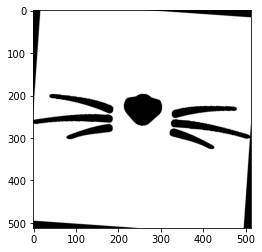

In [15]:
rows, cols = img_sticker.shape[:2]

# 이미지의 중심점을 기준으로 degree도 회전
M= cv2.getRotationMatrix2D((cols/2, rows/2),degree,1)

rotated_sticker = cv2.warpAffine(img_sticker, M,(cols, rows))

df0 = pd.DataFrame(rotated_sticker[:,:,0].ravel())
print(df0.value_counts())
df1 = pd.DataFrame(rotated_sticker[:,:,1].ravel())
print(df1.value_counts())
df2 = pd.DataFrame(rotated_sticker[:,:,2].ravel())
print(df2.value_counts())

plt.imshow(rotated_sticker)
plt.show()

- ### cv2 warpAffine 과 getRotationMatrix2D 을 사용하여 rotate transform 시켰더니 배경에 검정색이 추가되었으며 0과 255 외의 값인 노이즈가 낀 상태로 회전된다.
- ### PIL 의 rotate함수로 회전시켜보자.

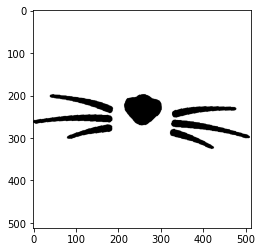

pil_ratated_sticker : <class 'PIL.Image.Image'>
pil_ratated_sticker.size :  (512, 512)
np_pil_ratated_sticker.shape : (512, 512)
0      244257
255     15527
12         33
254        30
120        29
        ...  
48          2
137         2
113         2
130         2
132         1
Length: 256, dtype: int64


In [16]:
from PIL import Image

pil_sticker = Image.open(sticker_path)

pil_ratated_sticker = pil_sticker.rotate(degree)

plt.imshow(pil_ratated_sticker)
plt.show()

print('pil_ratated_sticker :',type(pil_ratated_sticker))
print('pil_ratated_sticker.size : ',pil_ratated_sticker.size)

np_pil_ratated_sticker= np.array(pil_ratated_sticker)

print('np_pil_ratated_sticker.shape :' ,np_pil_ratated_sticker.shape)

df = pd.DataFrame(np_pil_ratated_sticker.ravel())
print(df.value_counts())

- ### 직전에 opencv를 통해 회전한 것과 달리 회전반경 배경에 검은색이아니고 흰색바탕으로 깔끔하지만 값을 살펴보니 역시 noize가 끼어있다.

- ### 이미지 행렬을 일정각도로 회전하면 내가 생각한데로  회전이 안된다는 것을 깨달았다.

- ### 일단 PIL rotate image를 쓸거긴 한데 PIL이 단일채널로 이미지를 읽어와 추후에 shape가 안맞아 문제가 생기니 3-channel image로 만들어논다

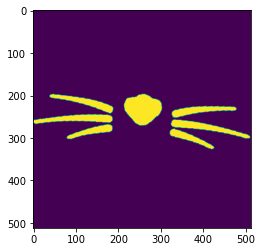

In [17]:
ch3_ratated_sticker = np.ones((512,512,3), dtype='uint8')

ch3_ratated_sticker[:,:,0] = 255 - np_pil_ratated_sticker
ch3_ratated_sticker[:,:,1] = 255 - np_pil_ratated_sticker
ch3_ratated_sticker[:,:,2] = 255 - np_pil_ratated_sticker

'''
np.savetxt('./ch3_ratated_sticker0',ch3_ratated_sticker[:,:,0])
np.savetxt('./ch3_ratated_sticker1',ch3_ratated_sticker[:,:,1])
np.savetxt('./ch3_ratated_sticker2',ch3_ratated_sticker[:,:,2])

np.savetxt('./img_sticker0',img_sticker[:,:,0])
np.savetxt('./img_sticker1',img_sticker[:,:,1])
np.savetxt('./img_sticker2',img_sticker[:,:,2])
'''

plt.imshow(np_pil_ratated_sticker)
plt.show()

- ### 위 이미지는 plt 가 이미지를 출력하는 과정에서 color type을 받아들이는 차이때문이며 직전에 3 channel로 만들어논 image는  원본 sticker image와 동일한 값의 형태를 갖는다. 왜 정확히 저리되는지는 라이브러리마다 이미지를 처리하는 과정이 다 달라서 개같기에 알고싶지 않다.

In [18]:
print(ch3_ratated_sticker.shape)

(512, 512, 3)


# 6. rotated sticker image resize

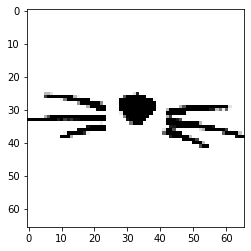

(66, 66, 3)


In [19]:
resized_img_sticker = cv2.resize(ch3_ratated_sticker, (int(w),int(h)))

plt.imshow(resized_img_sticker)
plt.show()
print(resized_img_sticker.shape)

- ### ~~ resized 스티커 이미지가 너무 깨져서 cv.resize에 보간법을 바꿔가며 실행해보자 ~~
#### * 사실 sticker image를 bounding box 보다 작은 비율로 줄였을때 노이즈가 많이 껴 하던 방식.
#### * interpolation별 비교 코드는 삭제함.

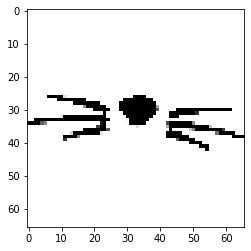

In [20]:
# INTER_NEAREST
resized_img_sticker1 = cv2.resize(ch3_ratated_sticker, (int(w),int(h))
                                 , interpolation=cv2.INTER_NEAREST)

plt.imshow(resized_img_sticker1)
plt.show()

- ### ~~ interpolation(보간법) param으로 INTER_NEAREST 사용할 예정이다 (noise가 적어보이기 때문) <br> -> resized_img_sticker1  ~~

# 7. Image ROI for sticker image
- ### 원본 image에 스티커가 들어갈 ROI를 정해주자~
 -> 아까 정한 list_points[30 에 sticker의 center point가 들어가게 할 것이다

In [21]:
print('sticker\'s center point가 위치할 landmark point :', list_points[30])

sticker's center point가 위치할 landmark point : (331, 244)


In [22]:
sticker_center_x = list_points[30][0]
sticker_center_y = list_points[30][1]
print(sticker_center_x, sticker_center_y)

resized_w = resized_img_sticker1.shape[0]
resized_h = resized_img_sticker1.shape[0]
print(resized_w,resized_h)


331 244
66 66


- ### sticker image가 들어갈 ROI 설정

In [23]:
roi_y = sticker_center_y - int(resized_h/2)
roi_y_puls_h = sticker_center_y + int(resized_h/2)
roi_x = sticker_center_x - int(resized_w/2)
roi_x_puls_w = sticker_center_x + int(resized_w/2)

In [24]:
sticker_area = img_rgb[roi_y : roi_y_puls_h, roi_x : roi_x_puls_w]
print(sticker_area.shape)

(66, 66, 3)


- ### 여태 처리하던 이미지에 스티커를 입혀보자

In [25]:
img_rgb[roi_y : roi_y_puls_h,roi_x : roi_x_puls_w] = \
        np.where(resized_img_sticker1==255,sticker_area,resized_img_sticker1).astype(np.uint8)

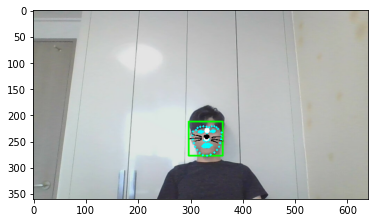

In [26]:
plt.imshow(img_rgb)
plt.show()

- ### 원본 이미지에 적용시켜 보자

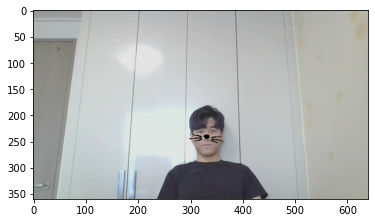

In [27]:
sticker_area = img_origin[roi_y : roi_y_puls_h, roi_x : roi_x_puls_w]

img_origin[roi_y : roi_y_puls_h, roi_x : roi_x_puls_w] = \
        np.where(resized_img_sticker1==255,sticker_area,resized_img_sticker1).astype(np.uint8)
plt.imshow(img_origin)
plt.show()

# 8. 마지막으로 위의 코드 중 얼굴과 landmark detection 하는 과정만 가져와서 함수로 만들어 여러 상황에 대한 인식률을 체크해보자

In [28]:
def face_detection(image_name):
    my_image_path = os.getenv('HOME')+'/camera_sticker/images/'+image_name+'.jpg'
    img_bgr = cv2.imread(my_image_path)
    img_bgr = cv2.resize(img_bgr, (640, 360))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    #img_origin = copy.deepcopy(img_rgb)
    
    detector_hog = dlib.get_frontal_face_detector() 
    dlib_rects = detector_hog(img_rgb, 2)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
        
    model_path = os.getenv('HOME')+'/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []
    
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    for landmark in list_landmarks:
        for idx, point in enumerate(landmark):
            cv2.circle(img_rgb, point, 2, (0, 255, 255), -1)
    
    plt.imshow(img_rgb)
    plt.show()

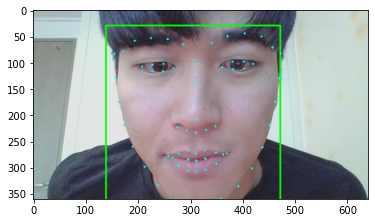

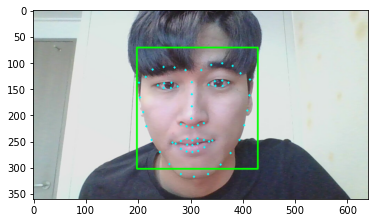

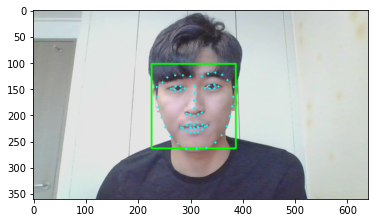

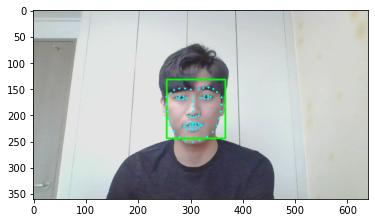

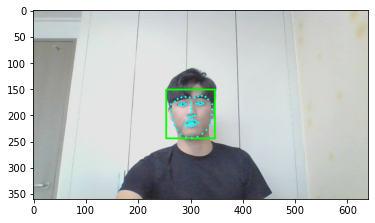

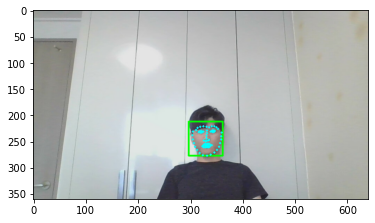

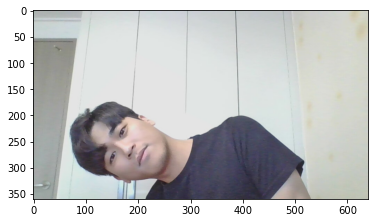

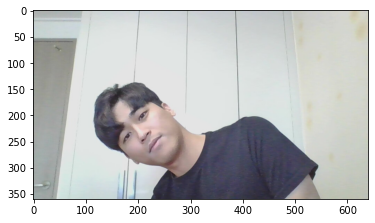

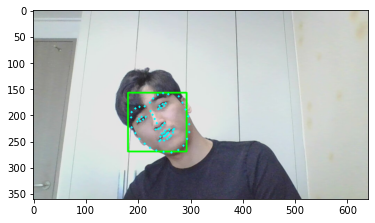

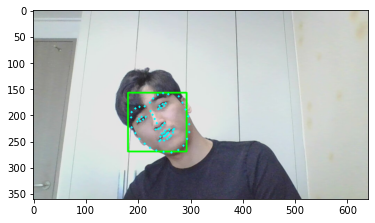

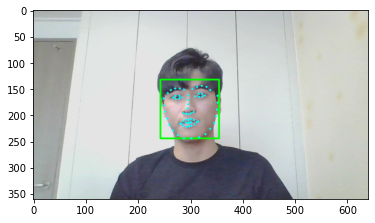

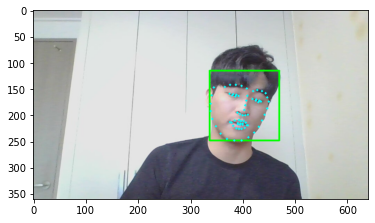

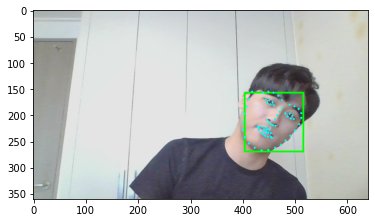

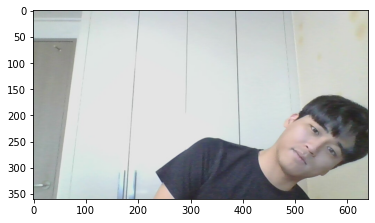

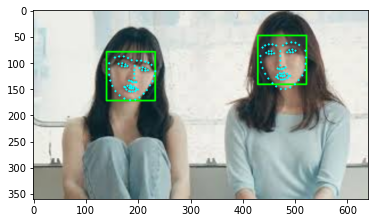

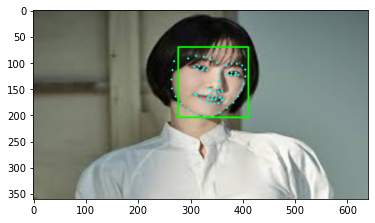

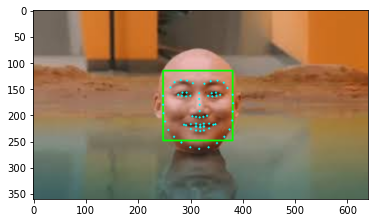

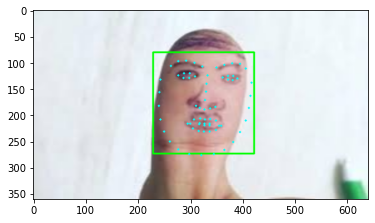

In [29]:
for i in range(1,19):
    face_detection(str(i))

- ### 일단 정면 얼굴은 다 인식하고 기울어진 정도는 45도 정도까지 커버하는듯

- ### 두명 얼굴도 잘 잡고 대머리도 잘잡는데. <br>

- ### 엄지손가락도 잡았다.

# Summary
---

## 1. 어려웠던 점
 - ### opencv의 이미지 픽셀을 나타내는 방식이 우리가 익숙한 좌표체계와 달라서 싫다.
 - ### opencv, PIL, pyplot 등의 라이브러리가 서로 이미지 처리하는 방식이 다 달라서 싫었다.
 - ### dlib의 frontal_face_detector가 bounding box를 내놓을때 매번 정확한 정사각형 형태가 아니어서 싫었다.

## 2. 알아낸 점
 - ### 이미지 matrix 를 회전시킬때 뭔가 내가 생각하는 pixel 값이 딱딱 맞아떨어지게끔 회전하는게 당연하게도 아니었다.

## 3. 시도한 idea
 - ### detect된 landmark를 통해 얼굴이 기울어진 정도를 계산하여 sticker image도 그만큼 회전시켜 원본 이미지에 적용시켰다.
 - ### sticker 가 입혀질 위치를 face detector가 찾은 bounding box에 일정한 비율로 resize 시켜줌. <br> -> 얼굴이 가깝든 멀든 bounding box의 크기에 따라 스티커도 그에맞는 사이즈로 맞춤.
 
## 4. 시도못한 idea
 - ### frontal_face_detector가 얼굴이 기울어진 정도, 얼굴의 얼마나 떨어져있는지 정도에 따른 인식률 분석은 대강 하였지만 얼굴이 기울어진 정도가 아닌 회전된? 정도에따른 인식률 분석 및 회전 정도에 따른 스티거 이미지 조정은 귀찮아서  못했다.
 - ### opencv의 여러 blur함수들을 통해 rotated sticker image에 어느정도 노이즈를 잡을 수 있었지만 귀찮아서 못했다.

## 5. 추후에...
 - ### 이번에 사용한 DLib의 fhog 방식 외에 OpenCV의 Haar Cascade Classifier 모델, DLib CNN 모델, Multi-task Cascaded CNN 모델 등등 다른 face detector 모델들을 사용해보면 좋을듯 하다.
 - ### 최적의 모델을 사용해 실시간으로 face detecting을 하고 실시간으로 sticker를 적용시켜 사진을 찍기전 미리보기? 할 수 있는 형태로 만들 수 있으면 좋을듯 하다.